In [87]:
import pandas_ml as pdml
import operator
import time
import matplotlib 
import matplotlib.pyplot as plt 
import sklearn
from sklearn import cross_validation,metrics,datasets, preprocessing, linear_model,svm,neighbors,grid_search,dummy
import pandas as pd 
import seaborn as sns 
import xgboost as xgb 
import numpy as np
import scipy.io
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
%matplotlib inline 

#set seed for all randomized algos 
seed = 42 
print("preambles loaded.")

preambles loaded.


In [3]:
#the usual utils 


    


def load_dataset(path="/home/faker/下載/data.csv"):
    import pandas as pd
    data = pd.read_csv(path)
    print("data loaded.")
    return data

def seperator(message):
    print()
    print("-"*80)
    print(message)
    print("-"*80)
    print()
    
def make_kaggle_submit_csv(predictions): 
    return predictions

def logging(message="\n"):
    current_time = time.ctime()
    path = "/home/faker/下載/logging.txt"
    with open(path,"a") as f: 
        f.write("-"*80 + "\n")
        f.write(current_time+"\n")
        f.write(message)
        f.write("\n")
        
#plotting utils 
def plot_roc_curve(false_positive_rates,true_positive_rates,auc_score):
    plt.plot([0,1],[0,1],"k--")
    plt.plot(false_positive_rates,true_positive_rates,"r-",label = "ROC curve (auc: %0.3f)"%(auc_score))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("false positive rate (1 - specificity)")
    plt.ylabel("true polsitive rate(sensitivity)")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()
    
def plot_validation_curve(train_scores,validation_scores,ticks,semilogx = False):
    if semilogx: 
        plt.semilogx(ticks,train_scores.mean(axis=1),"b--",label = "training")
        plt.fill_between(ticks,train_scores.mean(axis=1)-train_scores.std(axis=1),
                        train_scores.mean(axis=1)+train_scores.std(axis=1),alpha=0.2,color="b")
        plt.semilogx(ticks,validation_scores.mean(axis=1),"r--",label="validation")
        plt.fill_between(ticks,validation_scores.mean(axis=1)-validation_scores.std(axis=1),
                        validation_scores.mean(axis=1)+validation_scores.std(axis=1),alpha=0.2,color="r")
    else: 
        plt.plot(ticks,train_scores,"b--",label = "training")
#         plt.fill_between(ticks,train_scores.mean(axis=1-train_scores.std(axis=1),
#                         train_scores.mean(axis=1)+train_scores.std(axis=1),alpha=0.2,color="b")
        plt.plot(ticks,validation_scores,"r--",label="validation")
#         plt.fill_between(ticks,validation_scores.mean(axis=1)-validation_scores.std(axis=1),
#                         validation_scores.mean(axis=1)+validation_scores.std(axis=1),alpha=0.2,color="r")
        
    plt.legend(loc="best")
    plt.show()

def get_numpy_arrays(data_raw):
    x = mat["X"]
    y = mat["Y"] #encoded as 1,2 
    y = y.reshape((y.shape[0],))
    #change encoding of 1,2 to 0,1 
    y[y==1] = 0 
    y[y==2] = 1
    # print(y)
    return(x,y)

def get_pandas_df(numpy_x,numpy_y,verbose=False):
    feature_names = [str(i) for i in range(numpy_x.shape[1])]
    #convert to pandas df 
    data_x = pd.DataFrame(numpy_x,columns=feature_names)
    data_y = pd.Series(numpy_y,name="y")
    if verbose:
        print("convertd to pandas df!! \n")
        seperator("data_x:")
        print(data_x.info())
        seperator("top 5 rows of data_x:")
        print(data_x.head(5))
        seperator("data_y:")
        print(data_y.value_counts())
        seperator("percentage of classes:")
        print(data_y.value_counts(normalize=True))
        
    return(data_x,data_y)

def combine_train_x_y_df(data_x,data_y):
    data = pd.concat([data_x,data_y],axis=1)
    return data

def visualize_pair_wise(data,feautures=None,cols_index_range = None,target="SHEDDING_SC1"):
    
    #see all pairwise relationship between features 
    if cols_index_range:
        f = data.columns[cols_index_range]
    else:
        f = feautures
    assert len(f) <= 10, "common man, too many features to fit in a plot!"
    
    g = sns.PairGrid(data,vars=f,hue=target)
    g.map_diag(sns.kdeplot)
    g.map_upper(sns.regplot)
    g.map_lower(sns.residplot)
    plt.legend()
    plt.show()




def visualize_distro(data,features=None,cols_index_range = None,target="SHEDDING_SC1"): 
    #sumary stats
    if cols_index_range: 
        tiny_x= data.iloc[:,cols_index_range]
    else:
        tiny_x= data.loc[:,features]
    for f in tiny_x: 
        seperator("featuer:%s"%f)
        #vanilla dist plot 
        sns.distplot(tiny_x[f])
        plt.show()
        #I want a fucking distplot wiht the two classes 
        g = sns.FacetGrid(data=data,hue=target)
        g.map(sns.distplot,f)
        plt.legend()
        plt.show()
        print(tiny_x[f].describe())

def visualize_scatter(data,feature1=None,feature2=None,feature_idx1=None,feature_idx2=None,target ="SHEDDING_SC1" ):
    if feature_idx1 and feature_idx2:
        f1 = data.columns[feature_idx1]
        f2 = data.columns[feature_idx2]
    else:
        f1 = feature1
        f2 = feature2
    seperator("feature:%s Vs. feature:%s"%(f1,f2))
    sns.lmplot(data=data,x=f1,y=f2,order=1,hue=target,markers=["o","x"])
    plt.show()
    g = sns.FacetGrid(data=data,hue=target)
    g.map(sns.residplot,f1,f2)

def visaulize_muliple_curves():
    pass 


######################33
#from koby uncleaned 

def make_kaggle_submit(prediction,file_name):
    idx = pd.Series(data["shot_id"][data["y"].isnull()].values.astype(dtype =int))
    predict = pd.Series(prediction)
    submit = pd.concat([idx,predict],axis=1,ignore_index=True,join="inner")
    submit.columns = ["shot_id","shot_made_flag"]
    submit.to_csv(base_path+file_name,index=False)
    return submit
    
def score_prediction(prediction,label):
    from sklearn import metrics 
    log_loss = metrics.log_loss(label,prediction,normalize=True)
    auc_score = metrics.roc_auc_score(label,prediction)
    accuracy_score = metrics.accuracy_score(label,prediction)
    print("log loss:%5.10f, auc:%5.f, accuracy:%.f"%(log_loss,auc_score,accuracy_score))
    
    
#begin with categorical features
def visualize_categoricals(train,cols_index_range = range(10),target = "SHEDDING_SC1"):

    for f in train.columns[cols_index_range]:
        if train[f].dtype == "object":
            seperator(message=f)
            print(train[f].value_counts())
            print(train[f].value_counts(normalize = True,sort=True,ascending=False))
            sns.countplot(data=train,x=f,hue=target)
            plt.show()
            print(train[[f,target]].groupby(f).mean())

# # the numerical features 
# for f in train:
#     if train[f].dtype != "object":#numerical 
#         seperator(message=f)
#         sns.distplot(a=train[f],hist=True,kde=True,rug=False)
#         plt.show()
#         sns.boxplot(x="y",y=f,data=train)
#         plt.show()
#         print(train[f].describe())

In [4]:
mat = load_dataset()

data loaded.


/home/faker/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [107]:
data = mat 

In [108]:
data

,Unnamed: 0,STUDYID,SUBJECTID,AGE,GENDER,EARLYTX,SHAM,SHEDDING_SC1,SYMPTOMATIC_SC2,LOGSYMPTSCORE_SC3,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,0,DEE1 RSV,RSV004,25,Male,NaN,NaN,0,0,0.000000,...,12.532662,11.631458,13.896581,13.903687,4.135161,4.289781,4.021070,3.724385,4.059118,3.877894
1,1,DEE1 RSV,RSV020,31,Male,NaN,NaN,1,1,1.230449,...,12.557913,11.767506,14.018568,13.914918,4.463518,4.340088,3.985140,3.580096,4.305335,3.753165
2,2,DEE1 RSV,RSV010,30,Female,NaN,NaN,0,0,0.477121,...,12.871827,12.126795,14.080985,14.016000,4.407110,4.189024,3.660226,3.491922,3.884721,3.664057
3,3,DEE1 RSV,RSV009,23,Female,NaN,NaN,0,0,0.477121,...,12.739252,12.014540,14.031444,13.931760,4.251145,4.290979,3.800962,3.564763,4.108513,3.734474
4,4,DEE1 RSV,RSV018,22,Male,NaN,NaN,1,1,0.903090,...,13.115406,12.311844,14.212605,14.274644,4.195170,4.074056,3.667383,3.562381,3.843235,3.919386
5,5,DEE1 RSV,RSV001,28,Male,NaN,NaN,1,1,1.447158,...,12.527092,11.770394,13.791657,13.800629,4.230327,4.405762,3.558563,3.394369,4.087039,3.738717
6,6,DEE1 RSV,RSV016,22,Male,NaN,NaN,1,0,0.602060,...,12.403063,11.715393,13.865676,13.738634,4.138047,3.969427,3.585596,3.404330,3.953294,3.609600
7,7,DEE1 RSV,RSV002,31,Male,NaN,NaN,1,1,1.799341,...,12.328638,11.556839,13.796016,13.681678,4.094470,4.115922,3.789381,3.453442,4.174017,3.730168
8,8,DEE1 RSV,RSV017,39,Male,NaN,NaN,0,0,0.477121,...,12.546921,11.855533,13.857508,13.831044,4.426729,4.644844,3.829607,3.766278,4.068836,3.864348
9,9,DEE1 RSV,RSV019,21,Male,NaN,NaN,0,0,0.000000,...,12.327262,11.588866,13.811659,13.684793,4.252106,4.330048,3.838007,3.517846,4.052683,3.619678


# EDA / Feature engineering

In [155]:
train_df = pdml.ModelFrame(data, target='SHEDDING_SC1')
train_df

,Unnamed: 0,STUDYID,SUBJECTID,AGE,GENDER,EARLYTX,SHAM,SHEDDING_SC1,SYMPTOMATIC_SC2,LOGSYMPTSCORE_SC3,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,0,DEE1 RSV,RSV004,25,Male,NaN,NaN,0,0,0.000000,...,12.532662,11.631458,13.896581,13.903687,4.135161,4.289781,4.021070,3.724385,4.059118,3.877894
1,1,DEE1 RSV,RSV020,31,Male,NaN,NaN,1,1,1.230449,...,12.557913,11.767506,14.018568,13.914918,4.463518,4.340088,3.985140,3.580096,4.305335,3.753165
2,2,DEE1 RSV,RSV010,30,Female,NaN,NaN,0,0,0.477121,...,12.871827,12.126795,14.080985,14.016000,4.407110,4.189024,3.660226,3.491922,3.884721,3.664057
3,3,DEE1 RSV,RSV009,23,Female,NaN,NaN,0,0,0.477121,...,12.739252,12.014540,14.031444,13.931760,4.251145,4.290979,3.800962,3.564763,4.108513,3.734474
4,4,DEE1 RSV,RSV018,22,Male,NaN,NaN,1,1,0.903090,...,13.115406,12.311844,14.212605,14.274644,4.195170,4.074056,3.667383,3.562381,3.843235,3.919386
5,5,DEE1 RSV,RSV001,28,Male,NaN,NaN,1,1,1.447158,...,12.527092,11.770394,13.791657,13.800629,4.230327,4.405762,3.558563,3.394369,4.087039,3.738717
6,6,DEE1 RSV,RSV016,22,Male,NaN,NaN,1,0,0.602060,...,12.403063,11.715393,13.865676,13.738634,4.138047,3.969427,3.585596,3.404330,3.953294,3.609600
7,7,DEE1 RSV,RSV002,31,Male,NaN,NaN,1,1,1.799341,...,12.328638,11.556839,13.796016,13.681678,4.094470,4.115922,3.789381,3.453442,4.174017,3.730168
8,8,DEE1 RSV,RSV017,39,Male,NaN,NaN,0,0,0.477121,...,12.546921,11.855533,13.857508,13.831044,4.426729,4.644844,3.829607,3.766278,4.068836,3.864348
9,9,DEE1 RSV,RSV019,21,Male,NaN,NaN,0,0,0.000000,...,12.327262,11.588866,13.811659,13.684793,4.252106,4.330048,3.838007,3.517846,4.052683,3.619678


In [189]:
train_df=train_df.drop('CEL', 1)


In [191]:
df=train_df

In [192]:
#最強的df
df

,SHEDDING_SC1,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,0,7.716238,6.952170,9.626880,8.473160,3.820618,9.263958,5.684072,4.396325,12.225397,...,12.532662,11.631458,13.896581,13.903687,4.135161,4.289781,4.021070,3.724385,4.059118,3.877894
1,1,7.375250,7.669168,11.161018,8.566897,3.667594,9.602716,5.703216,4.535583,12.381075,...,12.557913,11.767506,14.018568,13.914918,4.463518,4.340088,3.985140,3.580096,4.305335,3.753165
2,0,8.069080,6.907841,10.451340,8.394821,3.886015,9.782746,5.813893,4.564077,12.842649,...,12.871827,12.126795,14.080985,14.016000,4.407110,4.189024,3.660226,3.491922,3.884721,3.664057
3,0,7.841501,7.378399,11.011024,8.468472,3.689041,9.756971,5.487063,4.507204,12.154011,...,12.739252,12.014540,14.031444,13.931760,4.251145,4.290979,3.800962,3.564763,4.108513,3.734474
4,1,8.125976,7.421352,10.850661,8.061855,3.709747,10.180188,5.975740,4.564912,13.152370,...,13.115406,12.311844,14.212605,14.274644,4.195170,4.074056,3.667383,3.562381,3.843235,3.919386
5,1,7.743979,7.113304,10.676258,8.356951,3.554301,9.667400,5.418621,4.322516,12.367807,...,12.527092,11.770394,13.791657,13.800629,4.230327,4.405762,3.558563,3.394369,4.087039,3.738717
6,1,7.874806,7.712536,11.031109,8.246123,3.608615,9.522059,5.241464,4.417967,12.251759,...,12.403063,11.715393,13.865676,13.738634,4.138047,3.969427,3.585596,3.404330,3.953294,3.609600
7,1,7.429711,7.497722,11.008060,8.322964,3.766860,9.356142,5.414599,4.444981,11.851971,...,12.328638,11.556839,13.796016,13.681678,4.094470,4.115922,3.789381,3.453442,4.174017,3.730168
8,0,7.940275,6.610546,10.246042,8.790348,3.817796,9.763198,5.667357,4.603406,11.894076,...,12.546921,11.855533,13.857508,13.831044,4.426729,4.644844,3.829607,3.766278,4.068836,3.864348
9,0,7.747783,7.223455,10.814135,8.244936,3.727916,9.553582,5.614140,4.617566,12.137691,...,12.327262,11.588866,13.811659,13.684793,4.252106,4.330048,3.838007,3.517846,4.052683,3.619678


In [193]:
train_df, test_df = train_df.cross_validation.train_test_split()
#now the train_df  , test_df  已經分開了

In [198]:
xgc = train_df.xgboost.XGBClassifier(objective="binary:logistic")
xgc

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [218]:
train_df.fit(xgc)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [219]:
train_df.cross_validation.cross_val_score(xgc, cv=3, scoring='log_loss')

array([-0.17757496, -0.17427094, -0.17679034])

In [202]:
train_df.fit(xgc, eval_metric='mlogloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

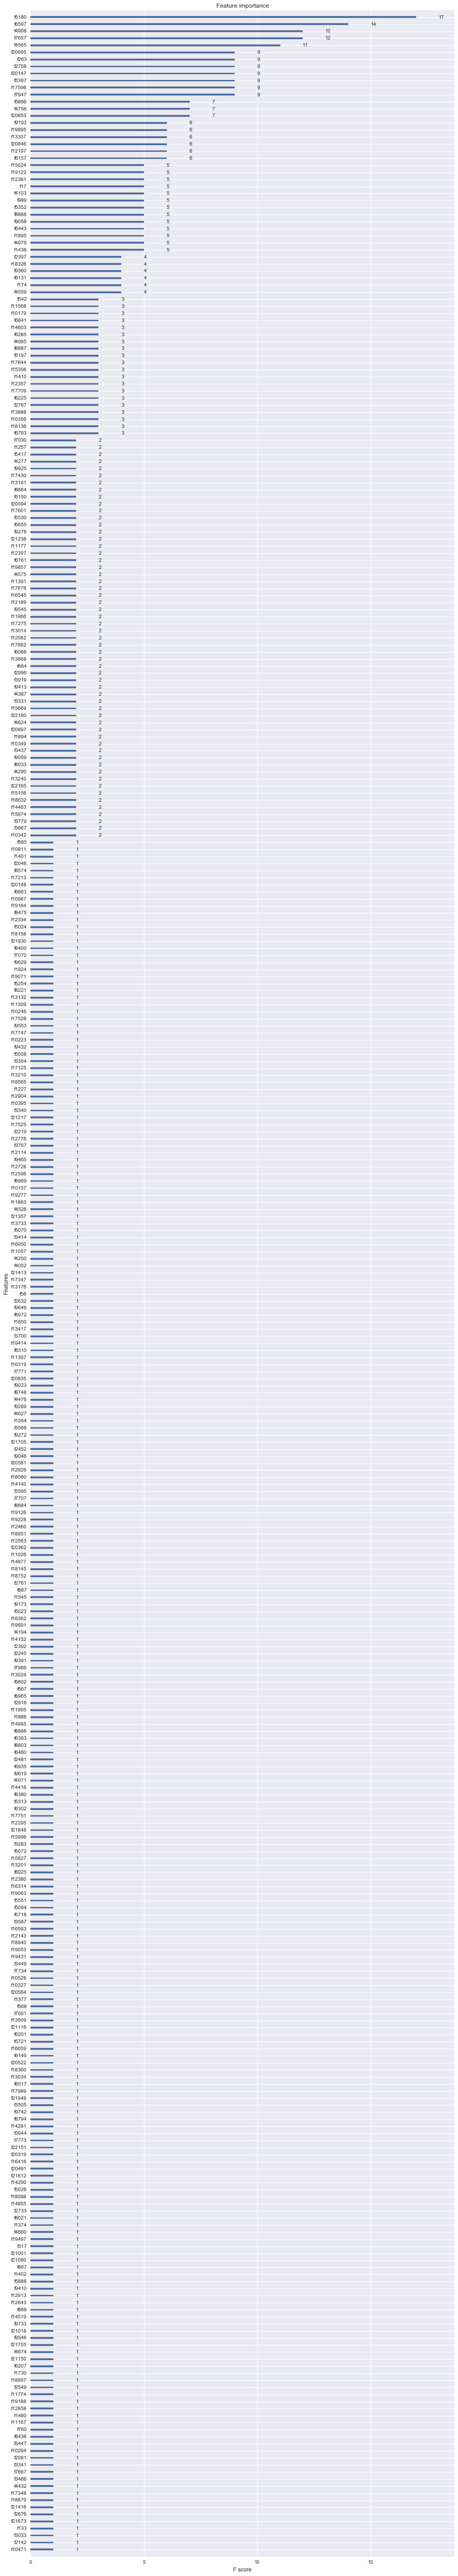

In [210]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 90))
train_df.xgboost.plot_importance(ax=ax)

In [221]:
# Predicting...
predicted = test_df.predict(xgc)
predicted


1711    1
1866    1
1028    0
174     1
290     1
1902    1
1421    0
215     1
684     0
2085    1
635     0
2205    1
2227    1
1285    1
1831    0
518     0
1076    0
1243    0
1679    1
2327    0
2046    1
1872    0
1012    1
2291    0
654     1
583     1
1723    0
781     0
981     0
316     1
       ..
1510    0
1225    0
1400    1
869     1
1390    0
2368    0
35      1
1992    0
1288    1
69      1
799     1
592     1
1800    0
1298    1
1039    1
2332    1
1336    0
948     0
341     0
926     1
1798    1
1304    1
2165    1
1735    0
814     0
1490    0
57      1
1641    1
119     1
200     1
dtype: int64

In [222]:
predicted.value_counts()

1    357
0    236
dtype: int64

In [223]:
test_df.metrics.confusion_matrix()

Predicted,0,1
Target,,
0,229,6
1,7,351


In [111]:
train_df.columns[12]

'CEL'

In [123]:

features = list(train_df.columns[13:])

In [145]:
y_train = train_df.SHEDDING_SC1
y_train

0       0
1       1
2       0
3       0
4       1
5       1
6       1
7       1
8       0
9       0
10      1
11      1
12      1
13      1
14      1
15      0
16      1
17      1
18      0
19      1
20      1
21      0
22      1
23      0
24      1
25      0
26      1
27      1
28      0
29      0
       ..
2341    1
2342    1
2343    1
2344    0
2345    1
2346    1
2347    1
2348    1
2349    0
2350    0
2351    0
2352    0
2353    1
2354    0
2355    1
2356    1
2357    1
2358    1
2359    1
2360    1
2361    1
2362    0
2363    1
2364    0
2365    0
2366    1
2367    1
2368    0
2369    1
2370    0
Name: SHEDDING_SC1, dtype: int64

In [128]:
x_train = train_df[features]


In [84]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [85]:
ceate_feature_map(features)

In [86]:
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 1000

dtrain = xgb.DMatrix(x_train, label=y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)


NameError: name 'operator' is not defined

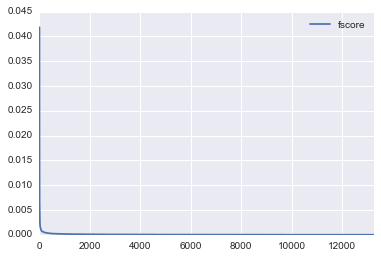

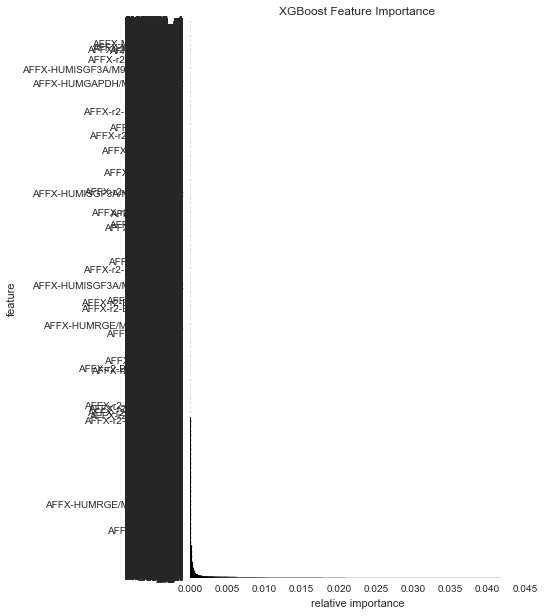

In [95]:

importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [115]:
df

,feature,fscore
0,1007_s_at,0.041831
1,1053_at,0.021015
2,117_at,0.017853
3,121_at,0.010387
4,1294_at,0.009738
5,1255_g_at,0.009089
6,1316_at,0.006440
7,1405_i_at,0.005979
8,1431_at,0.005330
9,1320_at,0.004953


In [144]:
#current x_train 2371 rows × 22277 columns (2371, 22277) , y_train
x_train

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,7.716238,6.952170,9.626880,8.473160,3.820618,9.263958,5.684072,4.396325,12.225397,4.519018,...,12.532662,11.631458,13.896581,13.903687,4.135161,4.289781,4.021070,3.724385,4.059118,3.877894
1,7.375250,7.669168,11.161018,8.566897,3.667594,9.602716,5.703216,4.535583,12.381075,4.408986,...,12.557913,11.767506,14.018568,13.914918,4.463518,4.340088,3.985140,3.580096,4.305335,3.753165
2,8.069080,6.907841,10.451340,8.394821,3.886015,9.782746,5.813893,4.564077,12.842649,4.393119,...,12.871827,12.126795,14.080985,14.016000,4.407110,4.189024,3.660226,3.491922,3.884721,3.664057
3,7.841501,7.378399,11.011024,8.468472,3.689041,9.756971,5.487063,4.507204,12.154011,4.172076,...,12.739252,12.014540,14.031444,13.931760,4.251145,4.290979,3.800962,3.564763,4.108513,3.734474
4,8.125976,7.421352,10.850661,8.061855,3.709747,10.180188,5.975740,4.564912,13.152370,4.427130,...,13.115406,12.311844,14.212605,14.274644,4.195170,4.074056,3.667383,3.562381,3.843235,3.919386
5,7.743979,7.113304,10.676258,8.356951,3.554301,9.667400,5.418621,4.322516,12.367807,4.479944,...,12.527092,11.770394,13.791657,13.800629,4.230327,4.405762,3.558563,3.394369,4.087039,3.738717
6,7.874806,7.712536,11.031109,8.246123,3.608615,9.522059,5.241464,4.417967,12.251759,4.324811,...,12.403063,11.715393,13.865676,13.738634,4.138047,3.969427,3.585596,3.404330,3.953294,3.609600
7,7.429711,7.497722,11.008060,8.322964,3.766860,9.356142,5.414599,4.444981,11.851971,4.322527,...,12.328638,11.556839,13.796016,13.681678,4.094470,4.115922,3.789381,3.453442,4.174017,3.730168
8,7.940275,6.610546,10.246042,8.790348,3.817796,9.763198,5.667357,4.603406,11.894076,4.954973,...,12.546921,11.855533,13.857508,13.831044,4.426729,4.644844,3.829607,3.766278,4.068836,3.864348
9,7.747783,7.223455,10.814135,8.244936,3.727916,9.553582,5.614140,4.617566,12.137691,4.471318,...,12.327262,11.588866,13.811659,13.684793,4.252106,4.330048,3.838007,3.517846,4.052683,3.619678


In [146]:
#train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_x.values,data_y.values,test_size=47,random_state=seed,stratify=data_y.values)
#X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.5)
#X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train,test_size=0.2,random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, random_state=0)

TypeError: Expected sequence or array-like, got estimator       1007_s_at   1053_at     117_at    121_at  1255_g_at    1294_at  \
0      7.716238  6.952170   9.626880  8.473160   3.820618   9.263958   
1      7.375250  7.669168  11.161018  8.566897   3.667594   9.602716   
2      8.069080  6.907841  10.451340  8.394821   3.886015   9.782746   
3      7.841501  7.378399  11.011024  8.468472   3.689041   9.756971   
4      8.125976  7.421352  10.850661  8.061855   3.709747  10.180188   
5      7.743979  7.113304  10.676258  8.356951   3.554301   9.667400   
6      7.874806  7.712536  11.031109  8.246123   3.608615   9.522059   
7      7.429711  7.497722  11.008060  8.322964   3.766860   9.356142   
8      7.940275  6.610546  10.246042  8.790348   3.817796   9.763198   
9      7.747783  7.223455  10.814135  8.244936   3.727916   9.553582   
10     7.750186  7.409776  10.424351  8.371509   3.873805   9.718960   
11     7.489422  7.180857  10.939194  7.826773   3.832859   9.515145   
12     7.688740  7.079452  10.587672  8.096790   3.683366   9.784223   
13     7.841925  7.185595  10.801537  8.441223   3.734336   9.648272   
14     7.661647  7.217798  11.177106  8.415057   4.108132   9.847892   
15     7.598817  7.244401  10.841527  8.016456   3.818923   9.345473   
16     7.759968  7.226875   9.967843  8.374175   3.867769   9.829155   
17     7.687139  7.177167  10.771050  7.891397   3.645738   9.577399   
18     7.483290  7.274679  11.438994  8.297686   3.721521   9.670166   
19     7.888925  6.927008  10.390591  8.870427   3.993977   9.566007   
20     7.483774  7.175459  10.660192  7.967101   3.864284   9.743108   
21     7.936499  7.313167  10.701558  8.285138   4.003879   9.543630   
22     7.977284  7.508366  10.201483  8.402428   3.637151   9.439177   
23     7.864315  7.131106  10.698851  8.534302   3.721682   9.786342   
24     7.713180  7.289703  10.354607  8.393211   3.733101   9.075026   
25     8.125470  7.186268   9.879806  8.611611   3.698480   9.774904   
26     8.110170  7.050539   9.716997  8.689132   3.972163   9.649773   
27     8.010224  7.121894   9.872277  8.254445   3.784380   9.885547   
28     7.926111  7.205947  10.818256  8.802693   3.747140   9.646515   
29     7.964063  7.289984   9.688495  8.241831   3.753952   9.704395   
...         ...       ...        ...       ...        ...        ...   
2341   7.647858  7.261536  10.883275  8.271759   3.778154   9.906993   
2342   7.871038  7.353610  10.615342  8.287734   3.743269   9.970117   
2343   7.622860  7.497529  10.526816  8.145712   3.780559   9.415926   
2344   7.953551  7.450069   9.963507  8.066003   3.882046   9.206670   
2345   7.671843  7.188005  10.834266  8.017069   3.869588  10.057698   
2346   7.724514  7.476401  10.413973  8.632721   3.835243   9.403406   
2347   7.278099  7.508999  10.967901  8.269696   4.134767   9.069724   
2348   7.968936  7.556525  10.199612  8.401027   4.170086   9.388019   
2349   7.886540  7.256082  10.149820  8.576159   3.854512   9.231095   
2350   7.586869  7.399555  10.450257  8.206706   3.722851   9.279966   
2351   8.730748  6.848962   9.278525  9.090181   3.868651   8.973013   
2352   8.049992  7.426840  10.382376  8.937937   3.859748   9.232256   
2353   8.396739  7.115171   9.758545  9.099143   3.762215   8.986345   
2354   8.532320  6.942142   9.444201  8.931483   3.980093   9.060426   
2355   7.762222  7.236835  10.440626  8.625363   3.694507   9.440557   
2356   8.023224  7.109457  10.274762  8.878567   3.880655   9.210841   
2357   8.008621  7.044647  10.230285  9.109633   3.833859   9.402390   
2358   8.086450  6.844958   9.872719  9.027791   3.760341   9.087554   
2359   8.673836  6.784790   9.612935  9.227386   3.919346   9.031337   
2360   8.131727  7.210797   9.729750  8.876864   3.757591   9.140037   
2361   8.377017  7.108174   9.827707  9.089110   3.901433   9.368152   
2362   8.366703  6.739826   9.836562  9.305551   3.973103   8.780686   
2363   8.298772  7.027811   9.591254  8.948054   3.817679   9.303849   
2364   8.276903  7.249058   9.494473  9.070633   3.766184   9.063391   
2365   8.470604  7.025872   9.313163  8.992171   3.851061   9.025439   
2366   8.347379  7.082458  10.313639  8.931256   3.875055   9.337249   
2367   7.823741  6.848559  10.581847  8.969208   3.826152   9.372506   
2368   8.366823  6.851915   9.607163  9.338420   3.751632   8.647810   
2369   8.454975  6.951279   9.443586  9.349135   3.734464   9.372509   
2370   8.262752  6.937687   9.848766  9.043328   3.912494   8.914642   

       1316_at   1320_at  1405_i_at   1431_at       ...         \
0     5.684072  4.396325  12.225397  4.519018       ...          
1     5.703216  4.535583  12.381075  4.408986       ...          
2     5.813893  4.564077  12.842649  4.393119       ...          
3     5.487063  4.507204  12.154011  4.172076       ...          
4     5.975740  4.564912  13.152370  4.427130       ...          
5     5.418621  4.322516  12.367807  4.479944       ...          
6     5.241464  4.417967  12.251759  4.324811       ...          
7     5.414599  4.444981  11.851971  4.322527       ...          
8     5.667357  4.603406  11.894076  4.954973       ...          
9     5.614140  4.617566  12.137691  4.471318       ...          
10    5.437329  4.109006  12.519675  4.231732       ...          
11    5.365863  4.331110  12.662957  4.152295       ...          
12    5.571181  4.300322  12.535854  4.397491       ...          
13    5.691694  4.310404  11.678582  4.289783       ...          
14    5.603530  4.621638  12.389698  4.313090       ...          
15    5.483156  4.309896  12.100069  4.328419       ...          
16    5.519330  4.357508  13.227974  4.241367       ...          
17    5.244491  4.397997  12.603686  4.332032       ...          
18    5.576698  4.386432  12.269986  4.545380       ...          
19    5.687193  4.537649  12.129839  4.637029       ...          
20    5.856125  4.431219  12.741802  4.675232       ...          
21    5.419260  4.342798  12.219787  4.383834       ...          
22    5.384478  4.239164  12.378761  4.488571       ...          
23    5.611787  4.468090  12.512106  4.423165       ...          
24    5.519940  4.295154  12.381543  4.305542       ...          
25    5.621178  4.583953  13.118653  4.585689       ...          
26    5.866260  4.664257  13.109093  4.464456       ...          
27    5.600788  4.141085  12.924673  4.441960       ...          
28    5.824999  4.522438  12.578265  4.265869       ...          
29    5.503000  4.290030  12.884714  4.383643       ...          
...        ...       ...        ...       ...       ...          
2341  5.624912  4.651360  12.096050  4.141201       ...          
2342  5.525094  4.273839  11.905242  4.348593       ...          
2343  5.491306  4.389298  12.187441  4.347292       ...          
2344  5.622081  4.546082  11.868934  4.400264       ...          
2345  5.591800  4.578646  11.591200  4.618838       ...          
2346  5.734329  4.574480  11.291527  4.229938       ...          
2347  5.669857  4.482993  11.398740  4.530635       ...          
2348  5.670398  4.435363  12.413241  4.316636       ...          
2349  5.799961  4.453485  11.786959  4.323422       ...          
2350  5.612032  4.364046  11.715279  4.425743       ...          
2351  5.865638  4.445847  11.828903  4.278036       ...          
2352  5.944249  4.318611  11.705310  4.459248       ...          
2353  6.022229  4.553909  12.080877  4.368752       ...          
2354  6.053467  4.726902  11.836115  4.392223       ...          
2355  5.934404  4.386145  12.160202  4.611641       ...          
2356  5.829562  4.719763  11.673888  4.324174       ...          
2357  5.907218  4.604466  10.994901  4.375049       ...          
2358  6.060800  4.453916  12.349400  4.373819       ...          
2359  5.763838  4.786794  11.873666  4.587765       ...          
2360  5.857327  4.399202  11.689413  4.405330       ...          
2361  5.786432  4.636275  11.865466  4.294184       ...          
2362  5.859974  4.631785  11.076167  4.240940       ...          
2363  5.936393  4.685327  11.544279  4.212773       ...          
2364  6.130239  4.728070  11.968411  4.366149       ...          
2365  6.485486  4.685040  11.891888  4.423840       ...          
2366  5.936701  4.625959  11.362815  4.467834       ...          
2367  5.904001  4.417631  11.372149  4.166047       ...          
2368  6.061113  4.650751  11.804924  4.262868       ...          
2369  6.166974  4.393098  12.531118  4.348051       ...          
2370  6.245431  4.521271  11.727198  4.454008       ...          

      AFFX-r2-Ec-bioD-3_at  AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  \
0                12.532662             11.631458            13.896581   
1                12.557913             11.767506            14.018568   
2                12.871827             12.126795            14.080985   
3                12.739252             12.014540            14.031444   
4                13.115406             12.311844            14.212605   
5                12.527092             11.770394            13.791657   
6                12.403063             11.715393            13.865676   
7                12.328638             11.556839            13.796016   
8                12.546921             11.855533            13.857508   
9                12.327262             11.588866            13.811659   
10               12.576572             11.770240            13.916682   
11               12.332083             11.621395            13.845165   
12               12.633541             11.763219            13.921978   
13               12.615627             11.916930            13.980907   
14               12.414777             11.639424            13.753927   
15               12.540022             11.735471            13.872452   
16               12.728084             11.967372            14.014551   
17               12.599542             11.846043            13.848123   
18               12.656170             11.851661            13.974042   
19               12.699600             11.975072            14.178430   
20               12.609758             11.877090            13.945017   
21               12.925590             12.171265            14.064454   
22               12.649470             11.834994            13.960368   
23               12.695847             11.914471            14.048267   
24               12.431276             11.746353            13.921569   
25               12.659205             11.897852            14.006721   
26               12.696713             11.866328            14.026233   
27               12.576890             11.761186            13.816539   
28               12.465545             11.685420            13.920843   
29               12.688876             11.908511            13.957795   
...                    ...                   ...                  ...   
2341             12.259022             11.355910            13.796025   
2342             12.549475             11.670323            13.939615   
2343             12.692911             11.922109            13.782212   
2344             13.070817             12.401830            14.133035   
2345             12.763732             11.977647            14.059365   
2346             12.224694             11.262167            13.749331   
2347             13.292279             12.600916            14.206953   
2348             13.265803             12.533754            14.190339   
2349             12.618369             11.791649            13.916006   
2350             12.449739             11.444881            13.890384   
2351             12.442755             11.649034            13.970954   
2352             12.506998             11.776900            14.041223   
2353             12.471753             11.707028            14.132874   
2354             12.483941             11.760132            13.965069   
2355             12.733795             11.941325            14.143114   
2356             12.530501             11.750015            14.080258   
2357             12.455659             11.785418            14.074208   
2358             12.468922             11.673425            14.057507   
2359             12.476502             11.616469            13.975260   
2360             12.719521             11.853364            14.068419   
2361             12.619329             11.923206            14.171473   
2362             12.525849             11.887267            14.076924   
2363             12.532801             11.770279            14.111433   
2364             12.517814             11.911004            14.134959   
2365             12.616774             11.857200            14.032187   
2366             12.610480             11.981313            14.151413   
2367             12.574667             11.943251            14.218373   
2368             12.497440             11.768398            14.051867   
2369             12.616520             11.814150            14.156684   
2370             12.420285             11.717469            14.065081   

      AFFX-r2-P1-cre-5_at  AFFX-ThrX-3_at  AFFX-ThrX-5_at  AFFX-ThrX-M_at  \
0               13.903687        4.135161        4.289781        4.021070   
1               13.914918        4.463518        4.340088        3.985140   
2               14.016000        4.407110        4.189024        3.660226   
3               13.931760        4.251145        4.290979        3.800962   
4               14.274644        4.195170        4.074056        3.667383   
5               13.800629        4.230327        4.405762        3.558563   
6               13.738634        4.138047        3.969427        3.585596   
7               13.681678        4.094470        4.115922        3.789381   
8               13.831044        4.426729        4.644844        3.829607   
9               13.684793        4.252106        4.330048        3.838007   
10              13.826131        4.284156        4.167680        3.629774   
11              13.655033        4.167298        4.176886        3.914286   
12              13.827470        4.320614        4.150984        3.710243   
13              13.846800        4.148882        3.905203        3.694811   
14              13.732141        4.451164        4.247819        3.758567   
15              13.699415        4.090118        4.170444        3.768981   
16              13.990094        4.317104        4.082988        3.764086   
17              13.743999        3.966324        4.064736        3.784830   
18              13.897357        4.219118        4.284923        3.813818   
19              14.306661        4.733898        4.370144        4.096684   
20              13.859901        4.174864        4.250146        3.836612   
21              14.048467        4.078067        4.097148        3.747839   
22              13.858469        4.195135        4.113825        3.900030   
23              13.948185        4.321586        4.071145        3.762918   
24              13.709893        4.365903        4.180149        3.764730   
25              13.966602        4.282395        4.222610        3.880476   
26              13.933340        4.589751        4.207702        3.925968   
27              13.791878        4.258857        4.184605        3.638985   
28              13.811340        4.271851        4.490531        3.862460   
29              13.911552        4.214947        4.150299        3.821685   
...                   ...             ...             ...             ...   
2341            13.764149        4.268443        4.239931        3.775341   
2342            13.863733        4.470233        3.905803        3.781899   
2343            13.791415        4.250946        4.182430        3.758040   
2344            14.084115        4.232766        4.550855        3.843489   
2345            14.010198        4.466135        4.434627        3.914846   
2346            13.658640        4.346135        4.119789        3.797812   
2347            14.236600        4.338526        4.358478        4.068236   
2348            14.222849        4.363603        4.102544        3.777600   
2349            13.855368        4.328345        4.222200        3.783042   
2350            13.774801        4.310023        4.273922        3.681336   
2351            14.012805        5.073747        4.473332        4.081897   
2352            14.075682        4.702416        4.621764        4.030182   
2353            14.158428        5.083692        4.486928        3.930273   
2354            14.143772        4.527226        4.469755        4.098416   
2355            14.290914        4.466597        4.260841        3.798477   
2356            14.206824        4.472565        4.335266        3.851782   
2357            14.173375        4.674866        4.447974        4.009654   
2358            14.026176        4.689697        4.457176        3.895565   
2359            14.044084        4.700486        5.025628        3.813969   
2360            14.180788        4.567919        4.532398        3.913638   
2361            14.224731        4.501190        4.507431        4.060946   
2362            14.133092        4.682501        4.734145        3.976335   
2363            14.157162        4.678430        4.354377        3.993541   
2364            14.192716        4.695210        4.476829        3.930035   
2365            14.208499        4.697335        4.575223        4.151783   
2366            14.258146        4.720292        4.651558        4.082968   
2367            14.247575        4.613924        4.194729        4.093124   
2368            14.120548        4.740683        4.524071        3.984746   
2369            14.235117        4.720807        4.278292        3.842102   
2370            14.248125        4.754626        4.256521        4.016137   

      AFFX-TrpnX-3_at  AFFX-TrpnX-5_at  AFFX-TrpnX-M_at  
0            3.724385         4.059118         3.877894  
1            3.580096         4.305335         3.753165  
2            3.491922         3.884721         3.664057  
3            3.564763         4.108513         3.734474  
4            3.562381         3.843235         3.919386  
5            3.394369         4.087039         3.738717  
6            3.404330         3.953294         3.609600  
7            3.453442         4.174017         3.730168  
8            3.766278         4.068836         3.864348  
9            3.517846         4.052683         3.619678  
10           3.716465         3.983764         3.851697  
11           3.579335         4.003480         3.567472  
12           3.568073         3.903635         3.666365  
13           3.476256         3.992031         3.762671  
14           3.598566         3.875495         3.801807  
15           3.609823         4.039312         3.847993  
16           3.490329         3.932739         3.711572  
17           3.512698         3.918140         3.678685  
18           3.591722         3.970999         3.828482  
19           3.632406         4.002553         3.685465  
20           3.778317         3.997189         3.874934  
21           3.704818         4.014412         3.734296  
22           3.524671         4.093993         3.691009  
23           3.491374         3.873095         3.838877  
24           3.649077         4.182501         3.793823  
25           3.570137         3.907239         3.682049  
26           3.501151         4.067736         3.753294  
27           3.604237         3.857433         3.816202  
28           3.532383         4.048314         3.825120  
29           3.482390         3.770843         3.787460  
...               ...              ...              ...  
2341         3.396736         4.054742         3.898319  
2342         3.444259         4.029552         3.862857  
2343         3.594314         4.138834         3.631712  
2344         3.835637         4.361622         3.782176  
2345         3.684351         4.252021         3.990434  
2346         3.602076         4.007603         3.999113  
2347         3.770950         4.302259         3.777870  
2348         3.615710         4.003780         3.790316  
2349         3.516875         4.034807         3.842897  
2350         3.520868         4.066358         3.738535  
2351         3.738009         4.067505         3.700788  
2352         3.719280         4.116255         3.615850  
2353         3.614703         4.049998         3.902176  
2354         3.478247         4.247449         3.698501  
2355         3.498836         4.099647         3.743049  
2356         3.699611         4.083026         3.705019  
2357         3.536461         3.947173         3.802150  
2358         3.654832         4.244108         3.756410  
2359         3.624175         3.992949         3.920637  
2360         3.717901         3.964759         3.770131  
2361         3.482469         4.102238         3.706107  
2362         3.617610         4.165072         3.848742  
2363         3.538752         4.040893         3.769165  
2364         3.653724         3.996710         3.759773  
2365         3.480618         4.040864         3.944829  
2366         3.704682         4.058411         3.914285  
2367         3.468014         3.984581         3.837548  
2368         3.548734         4.184854         3.999662  
2369         3.667876         4.001823         3.901779  
2370         3.578523         4.153861         3.762433  

[2371 rows x 22277 columns]

In [139]:

x_train.shape


(2371, 22277)

In [138]:
y_train.size

2371

In [116]:
train_df.target

0       0
1       1
2       0
3       0
4       1
5       1
6       1
7       1
8       0
9       0
10      1
11      1
12      1
13      1
14      1
15      0
16      1
17      1
18      0
19      1
20      1
21      0
22      1
23      0
24      1
25      0
26      1
27      1
28      0
29      0
       ..
2341    1
2342    1
2343    1
2344    0
2345    1
2346    1
2347    1
2348    1
2349    0
2350    0
2351    0
2352    0
2353    1
2354    0
2355    1
2356    1
2357    1
2358    1
2359    1
2360    1
2361    1
2362    0
2363    1
2364    0
2365    0
2366    1
2367    1
2368    0
2369    1
2370    0
Name: SHEDDING_SC1, dtype: int64

In [72]:
train_df = train_df.drop('Unnamed: 0', 1)
#remove useless feature

In [58]:
train_df

,STUDYID,SUBJECTID,AGE,GENDER,EARLYTX,SHAM,SHEDDING_SC1,SYMPTOMATIC_SC2,LOGSYMPTSCORE_SC3,TIMEHOURS,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,DEE1 RSV,RSV004,25,Male,NaN,NaN,0,0,0.000000,-24,...,12.532662,11.631458,13.896581,13.903687,4.135161,4.289781,4.021070,3.724385,4.059118,3.877894
1,DEE1 RSV,RSV020,31,Male,NaN,NaN,1,1,1.230449,-24,...,12.557913,11.767506,14.018568,13.914918,4.463518,4.340088,3.985140,3.580096,4.305335,3.753165
2,DEE1 RSV,RSV010,30,Female,NaN,NaN,0,0,0.477121,-24,...,12.871827,12.126795,14.080985,14.016000,4.407110,4.189024,3.660226,3.491922,3.884721,3.664057
3,DEE1 RSV,RSV009,23,Female,NaN,NaN,0,0,0.477121,-24,...,12.739252,12.014540,14.031444,13.931760,4.251145,4.290979,3.800962,3.564763,4.108513,3.734474
4,DEE1 RSV,RSV018,22,Male,NaN,NaN,1,1,0.903090,-24,...,13.115406,12.311844,14.212605,14.274644,4.195170,4.074056,3.667383,3.562381,3.843235,3.919386
5,DEE1 RSV,RSV001,28,Male,NaN,NaN,1,1,1.447158,-24,...,12.527092,11.770394,13.791657,13.800629,4.230327,4.405762,3.558563,3.394369,4.087039,3.738717
6,DEE1 RSV,RSV016,22,Male,NaN,NaN,1,0,0.602060,-24,...,12.403063,11.715393,13.865676,13.738634,4.138047,3.969427,3.585596,3.404330,3.953294,3.609600
7,DEE1 RSV,RSV002,31,Male,NaN,NaN,1,1,1.799341,-24,...,12.328638,11.556839,13.796016,13.681678,4.094470,4.115922,3.789381,3.453442,4.174017,3.730168
8,DEE1 RSV,RSV017,39,Male,NaN,NaN,0,0,0.477121,-24,...,12.546921,11.855533,13.857508,13.831044,4.426729,4.644844,3.829607,3.766278,4.068836,3.864348
9,DEE1 RSV,RSV019,21,Male,NaN,NaN,0,0,0.000000,-24,...,12.327262,11.588866,13.811659,13.684793,4.252106,4.330048,3.838007,3.517846,4.052683,3.619678


In [60]:
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)

NameError: name 'y' is not defined

In [61]:
xgc = train_df.xgboost.XGBClassifier

In [62]:
xgc

xgboost.sklearn.XGBClassifier


--------------------------------------------------------------------------------
STUDYID
--------------------------------------------------------------------------------

DEE3 H1N1          474
DEE1 RSV           417
DEE2 H3N2          351
Rhinovirus Duke    328
DEE5 H3N2          297
Rhinovirus UVA     289
DEE4X H1N1         215
Name: STUDYID, dtype: int64
DEE3 H1N1          0.199916
DEE1 RSV           0.175875
DEE2 H3N2          0.148039
Rhinovirus Duke    0.138338
DEE5 H3N2          0.125264
Rhinovirus UVA     0.121889
DEE4X H1N1         0.090679
Name: STUDYID, dtype: float64


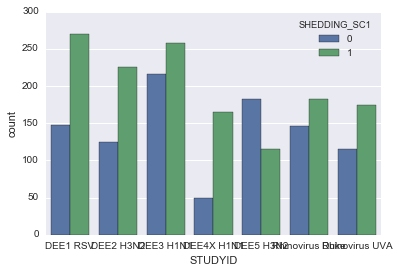

                 SHEDDING_SC1
STUDYID                      
DEE1 RSV             0.647482
DEE2 H3N2            0.643875
DEE3 H1N1            0.544304
DEE4X H1N1           0.767442
DEE5 H3N2            0.387205
Rhinovirus Duke      0.554878
Rhinovirus UVA       0.602076

--------------------------------------------------------------------------------
SUBJECTID
--------------------------------------------------------------------------------

RSV003    21
5001      21
RSV017    21
RSV008    21
RSV010    21
RSV002    21
5007      21
5021      21
5017      21
flu010    21
5015      21
5013      21
5011      21
5009      21
5008      21
5002      21
5016      21
RSV015    21
RSV004    21
RSV013    21
flu008    21
flu016    21
flu002    21
RSV011    21
flu017    21
4046      21
flu014    21
RSV020    21
flu007    21
flu003    21
          ..
10         2
4          2
5005       2
5007       2
6          2
7          2
5002       2
5016       2
5          2
5003       2
5015       2
5011      

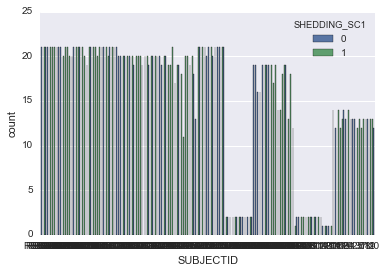

           SHEDDING_SC1
SUBJECTID              
1                     0
2                     0
3                     1
4                     1
5                     1
6                     1
7                     1
8                     0
9                     1
10                    0
11                    1
12                    1
13                    0
14                    0
15                    1
16                    1
17                    1
18                    0
19                    0
20                    1
3001                  1
3002                  0
3003                  1
3004                  0
3005                  0
3006                  1
3007                  0
3008                  1
3009                  1
3010                  1
...                 ...
RSV008                0
RSV009                0
RSV010                0
RSV011                1
RSV012                1
RSV013                1
RSV014                1
RSV015                1
RSV016          

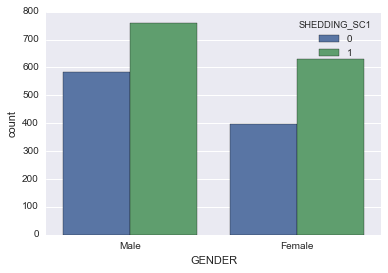

        SHEDDING_SC1
GENDER              
Female      0.614411
Male        0.564732

--------------------------------------------------------------------------------
SHAM
--------------------------------------------------------------------------------

sham    127
Name: SHAM, dtype: int64
sham    0.053564
Name: SHAM, dtype: float64


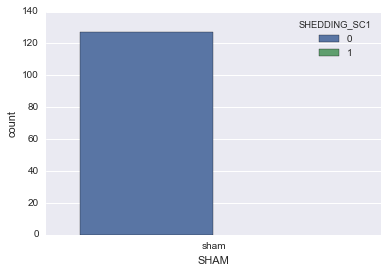

      SHEDDING_SC1
SHAM              
sham             0


In [7]:
visualize_categoricals(train=data,cols_index_range=range(10))


--------------------------------------------------------------------------------
featuer:200067_x_at
--------------------------------------------------------------------------------



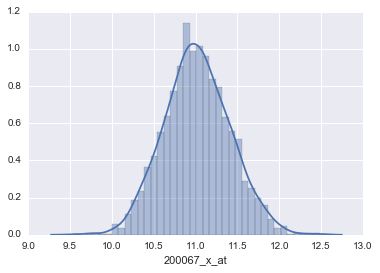

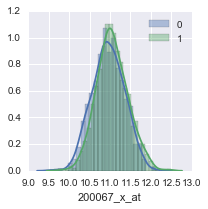

count    2371.000000
mean       11.018325
std         0.392972
min         9.533164
25%        10.754313
50%        11.008402
75%        11.281039
max        12.486363
Name: 200067_x_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200068_s_at
--------------------------------------------------------------------------------



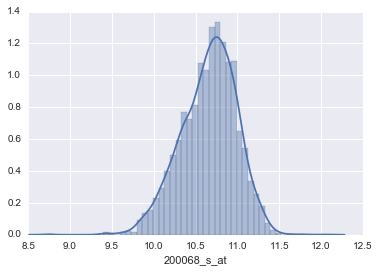

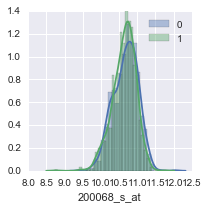

count    2371.000000
mean       10.656999
std         0.332212
min         8.731757
25%        10.441960
50%        10.690542
75%        10.889071
max        12.056848
Name: 200068_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200069_at
--------------------------------------------------------------------------------



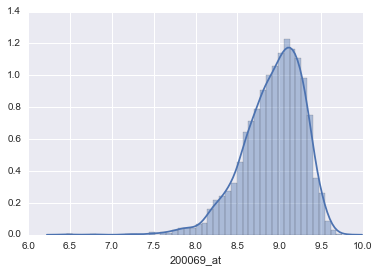

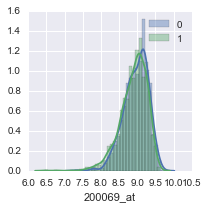

count    2371.000000
mean        8.928581
std         0.360321
min         6.458900
25%         8.719342
50%         8.981093
75%         9.192223
max         9.752835
Name: 200069_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200070_at
--------------------------------------------------------------------------------



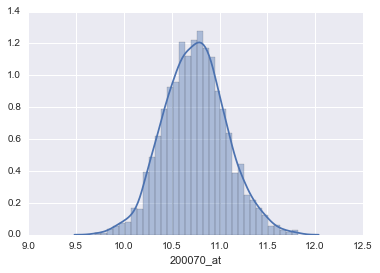

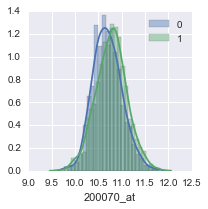

count    2371.000000
mean       10.745377
std         0.324943
min         9.696609
25%        10.525146
50%        10.746556
75%        10.952839
max        11.823358
Name: 200070_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200071_at
--------------------------------------------------------------------------------



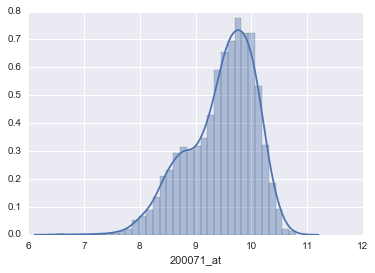

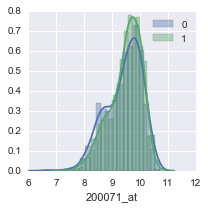

count    2371.000000
mean        9.464350
std         0.600906
min         6.521037
25%         9.083178
50%         9.574925
75%         9.914099
max        10.799018
Name: 200071_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200072_s_at
--------------------------------------------------------------------------------



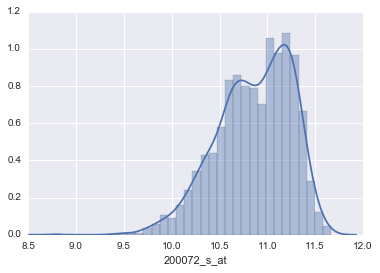

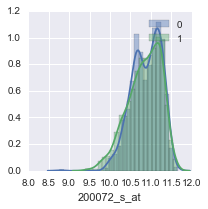

count    2371.000000
mean       10.861401
std         0.389379
min         8.764457
25%        10.603696
50%        10.906138
75%        11.174909
max        11.668240
Name: 200072_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200073_s_at
--------------------------------------------------------------------------------



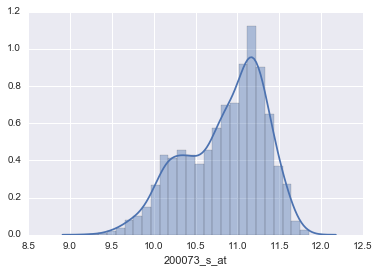

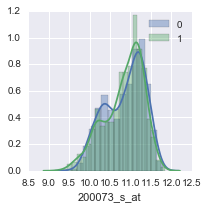

count    2371.000000
mean       10.851330
std         0.478611
min         9.231388
25%        10.490297
50%        10.950666
75%        11.216779
max        11.854128
Name: 200073_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200074_s_at
--------------------------------------------------------------------------------



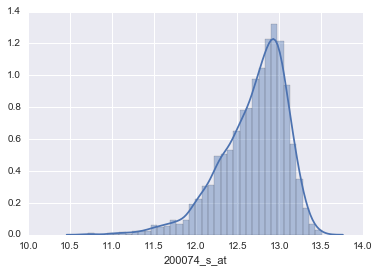

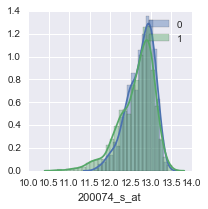

count    2371.000000
mean       12.694566
std         0.393891
min        10.713275
25%        12.471620
50%        12.772528
75%        12.980600
max        13.506638
Name: 200074_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200075_s_at
--------------------------------------------------------------------------------



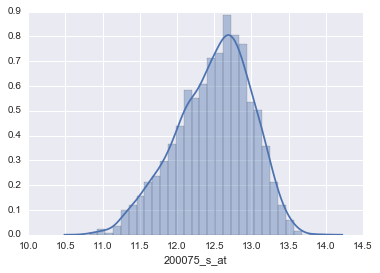

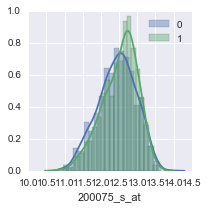

count    2371.000000
mean       12.492511
std         0.501504
min        10.822178
25%        12.154710
50%        12.553142
75%        12.860570
max        13.886034
Name: 200075_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200076_s_at
--------------------------------------------------------------------------------



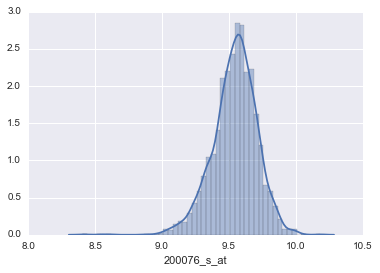

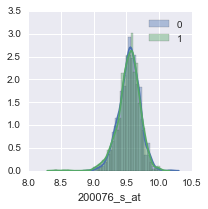

count    2371.000000
mean        9.541968
std         0.165900
min         8.405075
25%         9.447423
50%         9.554889
75%         9.651514
max        10.181981
Name: 200076_s_at, dtype: float64


In [8]:
visualize_distro(data,features=None,cols_index_range = range(100,110,1),target="SHEDDING_SC1")

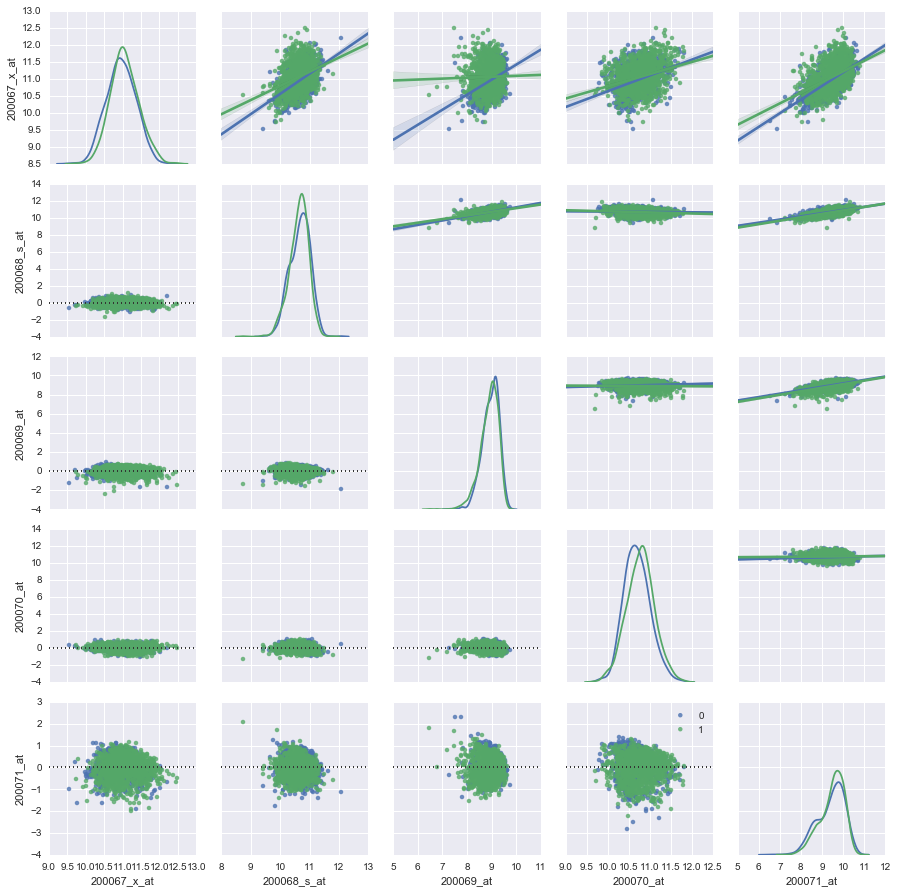

In [9]:
visualize_pair_wise(data,cols_index_range=range(100,105,1))


--------------------------------------------------------------------------------
feature:200067_x_at Vs. feature:200068_s_at
--------------------------------------------------------------------------------



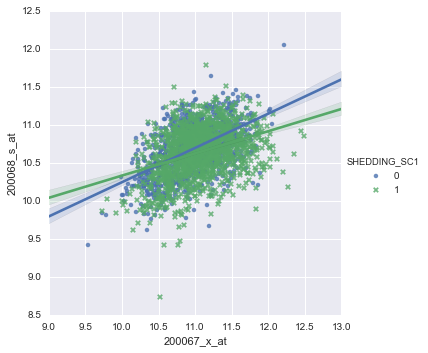

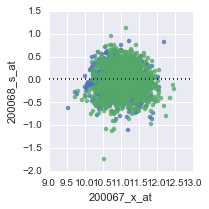

In [10]:
visualize_scatter(data,feature_idx1=100,feature_idx2=101)

# cross valdiation 

In [11]:
data["TIMEHOURS"].value_counts()

 12.0     111
 36.0     110
 0.0      109
-24.0     104
 84.0      87
 60.0      86
 108.0     84
 5.0       73
 93.5      73
 101.0     73
 45.5      72
 125.0     72
 117.5     72
 165.5     71
 77.0      71
 53.0      70
 69.5      70
 21.5      69
 141.5     67
 29.0      67
 42.0      50
 132.0     43
 24.0      40
 20.0      39
 16.0      39
 48.0      38
 30.0      38
 4.0       38
 72.0      37
 8.0       34
 120.0     34
 96.0      31
 136.0     14
 672.0     13
 34.0      13
 10.0      13
 18.0      13
 146.0     13
 2.0       13
 114.0     13
 170.0     13
 106.0     13
 50.0      13
 138.0     13
 58.0      13
 66.0      13
 162.0     13
-30.0      13
 82.0      13
 130.0     13
 90.0      13
 122.0     13
 98.0      13
 74.0      13
 26.0      12
Name: TIMEHOURS, dtype: int64

In [12]:
for f in data.columns:
    print(f)

Unnamed: 0
STUDYID
SUBJECTID
AGE
GENDER
EARLYTX
SHAM
SHEDDING_SC1
SYMPTOMATIC_SC2
LOGSYMPTSCORE_SC3
TIMEHOURS
SAMPLEID
CEL
1007_s_at
1053_at
117_at
121_at
1255_g_at
1294_at
1316_at
1320_at
1405_i_at
1431_at
1438_at
1487_at
1494_f_at
1598_g_at
160020_at
1729_at
177_at
1773_at
179_at
1861_at
200000_s_at
200001_at
200002_at
200003_s_at
200004_at
200005_at
200006_at
200007_at
200008_s_at
200009_at
200010_at
200011_s_at
200012_x_at
200013_at
200014_s_at
200015_s_at
200016_x_at
200017_at
200018_at
200019_s_at
200020_at
200021_at
200022_at
200023_s_at
200024_at
200025_s_at
200026_at
200027_at
200028_s_at
200029_at
200030_s_at
200031_s_at
200032_s_at
200033_at
200034_s_at
200035_at
200036_s_at
200037_s_at
200038_s_at
200039_s_at
200040_at
200041_s_at
200042_at
200043_at
200044_at
200045_at
200046_at
200047_s_at
200048_s_at
200049_at
200050_at
200051_at
200052_s_at
200053_at
200054_at
200055_at
200056_s_at
200057_s_at
200058_s_at
200059_s_at
200060_s_at
200061_s_at
200062_s_at
200063_s_at
20006

In [13]:
data_before = data.iloc[data["TIMEHOURS"]<=0,:]
print(data_before.info())
print(data_before.head())

NotImplementedError: iLocation based boolean indexing on an integer type is not available

In [16]:
data["SUBJECTID"].value_counts()

RSV003    21
5001      21
RSV017    21
RSV008    21
RSV010    21
RSV002    21
5007      21
5021      21
5017      21
flu010    21
5015      21
5013      21
5011      21
5009      21
5008      21
5002      21
5016      21
RSV015    21
RSV004    21
RSV013    21
flu008    21
flu016    21
flu002    21
RSV011    21
flu017    21
4046      21
flu014    21
RSV020    21
flu007    21
flu003    21
          ..
10         2
4          2
5005       2
5007       2
6          2
7          2
5002       2
5016       2
5          2
5003       2
5015       2
5011       2
5017       2
5009       2
11         2
5021       2
3          2
5008       2
1          2
12         2
2          2
5013       2
9          2
8          2
14         1
18         1
17         1
20         1
16         1
19         1
Name: SUBJECTID, dtype: int64